# RuCl Full Scale Example
The search for Kitaev Spin Liquid Materials is a very active area of Material Science Research.  One example of a candidate material that demonstrates promise as a Kitaev Spin Liquid is $\alpha$-RuCl$_3$. In this notebook, we explore the necessary steps to simulate the dynamics of this material on a Fault Tolerant Quantum Computer, assuming a gate-based architecture. For a good introduction to the properties of the material see the review article [here](https://www.nature.com/articles/s41535-019-0203-y).  The Hamiltonian for $\alpha$-RuCl$_3$ can be most generically represented in the form
\begin{equation}
\begin{split}
  H_{material} &= K_{x} \sum_{ij} S^{x}_{i} S^{x}_{j} + K_{y} \sum_{ij} S^{y}_{i} S^{y}_{j} + K_{z} \sum_{ij} S^{z}_{i} S^{z}_{j} + J \sum_{ij} \bf{S_i} \cdot \bf{S_j}\\
    &+ \Gamma_z \sum_{ij} (S^{x}_{i} S^{y}_{j} + S^{y}_{i} S^{x}_{j}) + \Gamma_y \sum_{ij} (S^{z}_{i} S^{x}_{j} + S^{x}_{i} S^{z}_{j}) + \Gamma_x \sum_{ij} (S^{y}_{i} S^{z}_{j} + S^{z}_{i} S^{y}_{j}) \\
    &+ \Gamma_z' \sum_{ij} (S^{x}_{i} S^{z}_{j} + S^{z}_{i} S^{x}_{j}) + (S^{x}_{i} S^{y}_{j} + S^{y}_{i} S^{x}_{j}) \\
    &+ \Gamma_y' \sum_{ij} (S^{y}_{i} S^{x}_{j} + S^{x}_{i} S^{y}_{j}) + (S^{y}_{i} S^{z}_{j} + S^{z}_{i} S^{y}_{j}) \\
    &+ \Gamma_x' \sum_{ij} (S^{z}_{i} S^{x}_{j} + S^{x}_{i} S^{z}_{j}) + (S^{z}_{i} S^{y}_{j} + S^{y}_{i} S^{z}_{j}) \\
    &+ A \sum_{i} (S^{z}_i)^{2} 
\end{split}
\end{equation}

The terms $S^{x}_{i}$, $S^{y}_{i}$, and $S^{z}_{i}$ represent the Pauli operators acting on site $i$.  The terms $K_{x}$, $K_{y}$, and $K_{z}$ represent the strength of the Kitaev interaction between two sites in a given direction.  The bold terms $\bf{S_i}$ $ = [S^x_i, S^y_i, S^z_i]$ are useful for defining the Heisenberg interaction terms with strength $J$.  The terms $\Gamma$ represent the strength of off-diagonal symmetric exchange interactions between nearest neighboring sites, and the terms $\Gamma'$ represent the effect of trigonal distortion.  Lastly, the term $A$ represents the effect of single-ion anisotropy.  

The connectivity of the Hamiltonian is defined directionally, as shown in Figure 1 (obtained from [[1]](https://doi.org/10.1038/s41535-019-0203-y)).  As a result of the experiment being performed on the material, we need to include a time-varying Hamiltonian component, corresponding to the time-varying Zeeman terms operating on the material. This Hamiltonian is
\begin{equation}
  H_{field}(t) = f_x(t) \sum_i S^x_i + f_y(t) \sum_i S^y_i + f_z(t) \sum_i S^z_i 
\end{equation}

We can then construct the complete time-varying Hamiltonian we want to simulate with 
\begin{equation}
  H(t) = H_{material} + H_{field}(t)
\end{equation}

<img src="EmbeddedFigures/RuclLattice.jpg" alt="RuCl Lattice" width="400"/>

##### Figure 1

In [1]:
import os
import time
import random
import pandas as pd
import numpy as np
from math import sqrt

from openfermion import count_qubits
from openfermion.circuits import trotter_steps_required, error_bound
from openfermion.circuits.trotter_exp_to_qgates import trotterize_exp_qubop_to_qasm

import networkx as nx
from networkx.generators.lattice import hexagonal_lattice_graph

import cirq
from cirq.contrib import qasm_import

from pyLIQTR.circuits.qsp import generate_QSP_circuit
from pyLIQTR.utils.Hamiltonian import Hamiltonian as pyH
from pyLIQTR.utils.utils import open_fermion_to_qasm, count_T_gates
from pyLIQTR.utils.qsp_helpers import circuit_decompose_once, circuit_decompose_once, print_to_openqasm
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform
from pyLIQTR.phase_factors.fourier_response.fourier_response import Angler_fourier_response

from qca.utils import count_gates, get_T_depth_wire, get_T_depth, plot_histogram, get_cpt_estimate
from qca.hamiltonian_utils import flatten_nx_graph, assign_hexagon_labels, pyliqtr_hamiltonian_to_openfermion_qubit_operator

/Users/jonhas/anaconda3/lib/python3.11/site-packages/attr/_make.py:918: RuntimeWarning: Running interpreter doesn't sufficiently support code object introspection.  Some features like bare super() or accessing __class__ will not work with slotted classes.
  set_closure_cell(cell, cls)


First we will define the functions that we are going to use to estimate the resources for simulating the dynamics of the Hamiltonian, $H$ described above. Since most of the common methods Hamiltonian simulation currently in use, for example Quantum Signal Processing (QSP) and Product formulas (e.g. Trotterization), we need to first break up the Hamiltonian into time independent steps using a Magnus expansion.  Here, we only use the first order Magnus expansion, which ultimately bottlenecks our precision, but we allow the user to specify a number of steps to ensure that the simulation is accurate enough for practical purposes.

### Magnus Expansion
The operation of the first order Magnus expansion is defined as follows:
\begin{equation}
U(s, s_0) \approx U_{mag_1} = \exp{\left(-i \int_{t0}^{t1} H(s) ds \right)}
\end{equation}

implying that we can treat the Hamiltonian as the argument of the exponential:
\begin{equation}
H(s, s_0) \approx H_{mag_1} = \int_{t0}^{t1} H(s) ds
\end{equation}

Note that when H has non-commuting component terms, $H = H_1 + H_2$ where $[H_1, H_2] \neq 0$, this  serves only as a first order method and higher order terms can be introduced for more precision.  For the sake of simplicity we choose to use the First order approximation.  As a further approximating step, in order to reduce overheads of compiling multiple circuits, we currently treat the time varying portion as a constant, representing a value somewhere in the middle of the dynamics.  In the future, we will likely improve these approximations to fully explore the time varying component and the potential improvement of using higher-order magnus expansions.

### Simulation Algorithms
In this notebook, we use two different algorithms for simulating the dynamics of $H$: QSP and second order Trotterization.  We explore both of these methods to better compare the resource requirements for each algorithm and see where tradeoffs, such as the parallelizability of T gates, exist.  It should be noted that the bounds which we use for estimating the Trotter error are loose, and it has been shown that using a lower number of steps is often sufficient.  For the implementation of QSP, we use [pyLIQTR](https://github.com/isi-usc-edu/pyLIQTR) and for the implementation of Trotterization, we use [openfermion](https://quantumai.google/openfermion).  Because the term ordering used by default is almost antagonistic with respect to circuit depth for most Hamiltonians with a lattice structure, we also define our own term ordering based on edge coloring.  While this may not be perfectly optimal, this coloring approach tends to get rather close empirically.

Due to the large circuit sizes required for implementing both of these algorithms, we take approaches to reduce the portion of the circuit directly stored in memory at any given time, and extrapolate the results for various subcircuits to obtain an approximate final estimate.  In the case of QSP, the circuits are provided in the form of high level circuit abstractions which may be decomposed later.  There is a high degree of repetition of the blocks in this high level abstraction, so we take one instance of each block, decompose it to its required clifford + T operations, and multiply that count by the number of occurences of the block.  For Trotterization, since each step is iterated multiple times, we simply compute the resources required for a single step and multiply those resource estimates by the number of steps.

In [2]:
t_init = time.perf_counter()
def estimate_qsp(pyliqtr_hamiltonian, timesteps, energy_precision, outdir, hamiltonian_name="hamiltonian", write_circuits=False, numsteps=1000):
    timestep_of_interest=timesteps/numsteps #for magnus like argument
    t0 = time.perf_counter()
    random.seed(0)
    np.random.seed(0)
    angles_response = Angler_fourier_response(tau=timestep_of_interest*pyliqtr_hamiltonian.alpha, eps=energy_precision, random=True, silent=True)
    angles_response.generate()
    angles = angles_response.phases

    qsp_circuit = generate_QSP_circuit(pyliqtr_hamiltonian, angles, pyliqtr_hamiltonian.problem_size)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to generate high level QSP circuit: " + str(elapsed) + " seconds")
    
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    subcircuit_counts = dict()
    t_counts = dict()
    t_depths = dict()
    t_depth_wires = dict()
    clifford_counts = dict()
    gate_counts = dict()
    subcircuit_depths = dict()
    
    outfile_data = outdir + hamiltonian_name + "_high_level.dat"
    
    for moment in qsp_circuit:
        for operation in moment:
            gate_type = type(operation.gate)
            if gate_type in subcircuit_counts:
                subcircuit_counts[gate_type] += 1
            
            else:
                outfile_qasm_decomposed = f'{outdir}{str(gate_type)[8:-2]}.decomposed.qasm'
                outfile_qasm_cpt = f'{outdir}{str(gate_type)[8:-2]}.cpt.qasm'
                
                t0 = time.perf_counter()
                decomposed_circuit = circuit_decompose_once(circuit_decompose_once(cirq.Circuit(operation)))
                t1 = time.perf_counter()
                elapsed = t1 - t0
                print("    Time to decompose high level " + str(gate_type)[8:-2] +" circuit: " + str(elapsed) + " seconds")
                
                t0 = time.perf_counter()
                cpt_circuit = clifford_plus_t_direct_transform(decomposed_circuit)
                t1 = time.perf_counter()
                elapsed = t1 - t0
                print("    Time to transform decomposed " + str(gate_type)[8:-2] + " circuit to Clifford+T: " + str(elapsed) + " seconds")
                
                if write_circuits:
                    with open(outfile_qasm_decomposed, 'w') as f:
                        print_to_openqasm(f, decomposed_circuit, qubits=decomposed_circuit.all_qubits())
                    
                    with open(outfile_qasm_cpt, 'w') as f:
                        print_to_openqasm(f, cpt_circuit, qubits=cpt_circuit.all_qubits())
                
                subcircuit_counts[gate_type] = 1
                subcircuit_depths[gate_type] = len(cpt_circuit)
                t_counts[gate_type] = count_T_gates(cpt_circuit)
                gate_counts[gate_type] = count_gates(cpt_circuit)
                t_depths[gate_type] = get_T_depth(cpt_circuit)
                t_depth_wires[gate_type] = get_T_depth_wire(cpt_circuit)
                clifford_counts[gate_type] = gate_counts[gate_type] - t_counts[gate_type]
                
    total_gate_count = 0
    total_gate_depth = 0
    total_T_depth = 0
    total_T_depth_wire = 0
    total_T_count = 0
    total_clifford_count = 0
    for gate in subcircuit_counts:
        total_gate_count += subcircuit_counts[gate] * gate_counts[gate] * timesteps / timestep_of_interest
        total_gate_depth += subcircuit_counts[gate] * subcircuit_depths[gate] * timesteps / timestep_of_interest
        total_T_depth += subcircuit_counts[gate] * t_depths[gate] * timesteps / timestep_of_interest
        total_T_depth_wire += subcircuit_counts[gate] * t_depth_wires[gate] * timesteps / timestep_of_interest
        total_T_count += subcircuit_counts[gate] * t_counts[gate] * timesteps / timestep_of_interest
        total_clifford_count += subcircuit_counts[gate] * clifford_counts[gate] * timesteps / timestep_of_interest
    with open(outfile_data, 'w') as f:
        total_gate_count 
        f.write(str("Logical Qubit Count:"+str(len(qsp_circuit.all_qubits()))+"\n"))
        f.write(str("Total Gate Count:"+str(total_gate_count)+"\n"))
        f.write(str("Total Gate Depth:"+str(total_gate_depth)+"\n"))
        f.write(str("Total T Count:"+str(total_T_count)+"\n"))
        f.write(str("Total T Depth:"+str(total_T_depth)+"\n"))
        f.write(str("Maximum T Count on Single Wire:"+str(total_T_depth_wire)+"\n"))
        f.write(str("Total Clifford Count:"+str(total_clifford_count)+"\n"))
        f.write("Subcircuit Info:\n")
        for gate in subcircuit_counts:
            f.write(str(str(gate)+"\n"))
            f.write(str("Subcircuit Occurrences:"+str(subcircuit_counts[gate]*timesteps)+"\n"))
            f.write(str("Gate Count:"+str(gate_counts[gate])+"\n"))
            f.write(str("Gate Depth:"+str(subcircuit_depths[gate])+"\n"))
            f.write(str("T Count:"+str(t_counts[gate])+"\n"))
            f.write(str("T Depth:"+str(t_depths[gate])+"\n"))
            f.write(str("Maximum T Count on a Single Wire:"+str(t_depth_wires[gate])+"\n"))
            f.write(str("Clifford Count:"+str(clifford_counts[gate])+"\n"))
    return qsp_circuit


def find_hamiltonian_ordering(of_hamiltonian):
    """
    Function to generate a near optimal term ordering for trotterization of transverse field Ising Models.
    This would need to be modified if there were multi-qubit interactions that were not just ZZ
    """
    #ordering hamiltonian terms by performing edge coloring to make optimal trotter ordering
    #assuming that any 2 body interactions are ZZ
    sorted_terms = sorted(list(of_hamiltonian.terms.keys()))
    sorted_terms.sort(key=lambda x: len(x) * 100 + ord(x[0][1])) #Z and X get translated to 90 and 88 respectively, multiplying by 100 ensures interacting term weight is considered
    one_body_terms_ordered = list(filter(lambda x: len(x) == 1, sorted_terms))
    two_body_terms = list(filter(lambda x: len(x) == 2, sorted_terms))
    
    #assigning edge colorings to order two body terms
    g = nx.Graph()
    for term in two_body_terms:
        edge = (term[0][0], term[1][0])
        g.add_edge(*edge)
    edge_coloring = nx.greedy_color(nx.line_graph(g))
    nx.set_edge_attributes(g, edge_coloring, "color")

    for (i,term) in enumerate(two_body_terms):
        n1,n2 = (term[0][0], term[1][0])
        color = g.edges[n1,n2]['color']
        term = (*term, color)
        two_body_terms[i] = term
    
    two_body_terms.sort(key=lambda x: x[2])
    two_body_terms_ordered = list()
    for (i,term) in enumerate(two_body_terms):
        new_item = (term[0],term[1])
        two_body_terms_ordered.append(new_item)
    return one_body_terms_ordered + two_body_terms_ordered

def estimate_trotter(openfermion_hamiltonian,timesteps, energy_precision, outdir, hamiltonian_name="hamiltonian", write_circuits=False):
    t0 = time.perf_counter()
    bounded_error = error_bound(list(openfermion_hamiltonian.get_operators()),tight=False)
    nsteps = trotter_steps_required(trotter_error_bound = bounded_error,
                                                time = timesteps, 
                                                energy_precision = energy_precision)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to estimate Number of steps required: " + str(elapsed) + " seconds")
    
    t0 = time.perf_counter()
    term_ordering = find_hamiltonian_ordering(openfermion_hamiltonian)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to find term ordering: " + str(elapsed) + " seconds")
    
    t0 = time.perf_counter()
    trotter_circuit_of = trotterize_exp_qubop_to_qasm(openfermion_hamiltonian, trotter_order=2, evolution_time=timesteps/nsteps, term_ordering=term_ordering)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to generate trotter circuit from openfermion: " + str(elapsed) + " seconds")
    
    qasm_str_trotter = open_fermion_to_qasm(count_qubits(openfermion_hamiltonian), trotter_circuit_of)
    trotter_circuit_qasm = qasm_import.circuit_from_qasm(qasm_str_trotter)
    
    t0 = time.perf_counter()
    cpt_trotter = clifford_plus_t_direct_transform(trotter_circuit_qasm)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to decompose trotter to Clifford + T: " + str(elapsed) + " seconds")
    
    #writing the the higher level trotter circuit to a file as well as the clifford + T circuit
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    if write_circuits:
        outfile_qasm_decomposed = outdir + "trotter_circuit_" + hamiltonian_name + ".qasm" 
        outfile_qasm_cpt = outdir + "trotter_cpt_" + hamiltonian_name + ".qasm"
        with open(outfile_qasm_decomposed, 'w') as f:
            print_to_openqasm(f, trotter_circuit_qasm, qubits=trotter_circuit_qasm.all_qubits())
        with open(outfile_qasm_cpt, 'w') as f:
            print_to_openqasm(f, cpt_trotter, qubits=cpt_trotter.all_qubits())
    
    t0 = time.perf_counter()
    outfile_data = outdir + "trotter_" + hamiltonian_name + ".dat"
    gate_count = count_gates(cpt_trotter)
    t_count = count_T_gates(cpt_trotter)
    t_depth = get_T_depth(cpt_trotter)
    t_depth_wire = get_T_depth_wire(cpt_trotter)
    with open(outfile_data, 'w') as f:
        f.write("Logical Qubit Count:"+str(len(cpt_trotter.all_qubits()))+"\n")
        f.write("Number of Trotter Steps Required (Loose Upper Bound):"+ str(nsteps) +"\n")
        f.write("Total T Depth:"+str(t_depth * nsteps)+"\n")
        f.write("Maximum T Count on a Single Wire:"+str(t_depth_wire * nsteps)+"\n")
        f.write("Single Step Gate Count:"+str(gate_count)+"\n")
        f.write("Single Step Gate Depth:"+str(len(cpt_trotter))+"\n")
        f.write("Single Step T Count:"+str(t_count)+"\n")
        f.write("Single Step T Depth:"+str(t_depth)+"\n")
        f.write("Single Step Maximum T Count on a Single Wire:"+str(t_depth_wire)+"\n")
        f.write("Single Step Clifford Count:"+str(gate_count - t_count)+"\n")
    
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to enumerate resource estimates: " + str(elapsed) + " seconds")
    
    return cpt_trotter

Next, we need to define the directional labels for the hexagonal lattice and add next-nearest and next-next-nearest neighbor interactions to the graph so we can construct the Hamiltonian from the connectivity graph later on.  This should match the connectivity defined in figure 1 above.  Note that we only consider cross-plaquette next-next-nearest neighbor interactions.  For the sake of visualization, we use a 3x3 lattice.  For the actual simulations, we will use a much larger lattice, defined below.

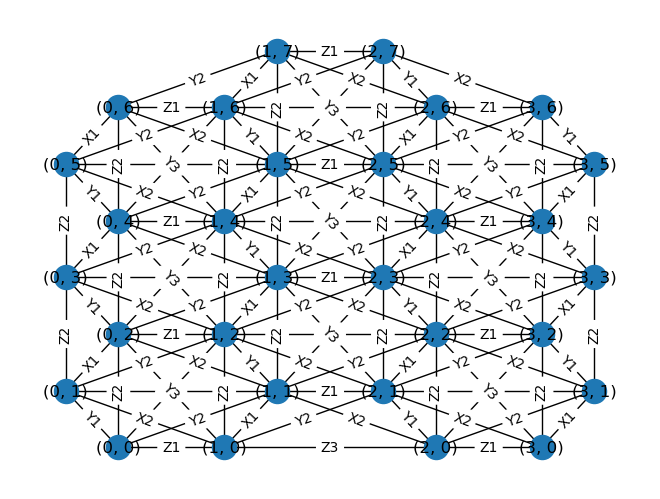

In [3]:
def assign_hexagon_labels_rucl(g):
    
    assign_hexagon_labels(g, 'X1', 'Y1', 'Z1')
       
    #Adding next nearest and next-next nearest neighbor edges and labels
    for n in g.nodes:
        r,c = n
        
        #next nearest neighbors
        if (r, c+2) in g:
            g.add_edge(n, (r, c+2), label = 'Z2')
        if (r+1, c+1) in g:
            g.add_edge(n, (r+1, c+1), label = "Y2")
        if (r-1, c+1) in g:
            g.add_edge(n, (r-1, c+1), label = "X2")
       
        #next-next nearest neighbors
        if (r+1, c) in g and not ((n, (r+1, c)) in g.edges):
            g.add_edge(n, (r+1,c), label = "Z3")
        if (r+1, c+2) in g and (r + c)%2 == 0:
            g.add_edge(n, (r+1, c+2), label="X3")
        if (r-1, c+2) in g and (r + c)%2 == 1:
            g.add_edge(n, (r-1, c+2), label="Y3")

g_rucl = hexagonal_lattice_graph(3,3)
pos = nx.get_node_attributes(g_rucl, 'pos')
assign_hexagon_labels_rucl(g_rucl)
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in g_rucl.edges(data=True)]);
nx.draw(g_rucl, pos, with_labels=True)
nx.draw_networkx_edge_labels(g_rucl, pos,edge_labels = edge_labels);

##### Figure 2

With the connectivity defined, we can construct a variety of Hamiltonians using the terms defined in [[1]](https://doi.org/10.1038/s41535-019-0203-y).  Some of the models contain more terms and thus take longer to run.  For the purposes of demonstration, row 13 tends to have the shortest runtime, so we use that for demonstration purposes here.  To run all rows, simply loop over all indices rather than just the 13th index.  The number after the terms in the following graph indicate how far away the interactions are.  For example J1 represents the nearest neighbor Heisenberg interactions, J2 represents the next-nearest neighbor Heisenberg interactions, and J3 represents the next-next-nearest neighbor Heisenberg interactions.  Any terms not present in the table that appear in the generic Hamiltonian defined above are treated as 0.

In [4]:
rucl_references = ["Winter et al. PRB", "Winter et al. NC", "Wu et al.", "Cookmeyer and Moore", "Kim and Kee", "Suzuki and Suga", 
              "Yadav et al.", "Ran et al.", "Hou et al.", "Wang et al.", "Eichstaedt et al.", "Eichstaedt et al.", 
              "Eichstaedt et al.", "Banerjee et al.", "Kim et al.", "Kim and Kee", "Winter et al.", "Ozel et al.", "Ozel et al."]

rucl_methods = ["Ab initio (DFT + exact diag.)", "Ab initio-inspired (INS fit)", "THz spectroscopy fit",
                "Magnon thermal Hall (sign)", "DFT + t=U expansion", "Magnetic specific heat", "Quantum chemistry (MRCI)",
                "Spin wave fit to INS gap", "Constrained DFT + U", "DFT + t=U expansion", "Fully ab initio (DFT + cRPA + t=U)",
                "Neglecting non-local Coulomb", "Neglecting non-local SOC", "Spin wave fit", "DFT + t=U expansion",
                "DFT + t=U expansion", "Ab initio (DFT + exact diag.)", "Spin wave fit/THz spectroscopy", "Spin wave fit/THz spectroscopy"]

rucl_J1 = [-1.7, -0.5, -0.35, -0.5, -1.53, -1.53, 1.2, 0, -1.87, -0.3, -1.4, -0.2, -1.3, -4.6, -12, -3.5, -5.5, -0.95, 0.46]
rucl_K1 = [-6.7, -5.0, -2.8, -5.0, -6.55, -24.4, -5.6, -6.8, -10.7, -10.9, -14.3, -4.5, -13.3, 7.0, 17., 4.6, 7.6, 1.15, -3.5]
rucl_Gam1 = [6.6, 2.5, 2.4, 2.5, 5.25, 5.25, 1.2, 9.5, 3.8, 6.1, 9.8, 3.0, 9.4, 0, 12., 6.42, 8.4, 3.8, 2.35]
rucl_Gam_prime1 = [-0.9, 0, 0, 0, -0.95, -0.95, -0.7, 0, 0, 0, -2.23, -0.73, -2.3, 0, 0, -0.04, 0.2, 0, 0]
rucl_J2 = [0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rucl_K2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.63, -0.33, -0.67, 0, 0, 0, 0, 0, 0]
rucl_J3 = [2.7, 0.5, 0.34, 0.1125, 0, 0, 0.25, 0, 1.27, 0.03, 1.0, 0.7, 1.0, 0, 0, 0, 2.3, 0, 0]
rucl_K3 = [0, 0, 0, 0, 0, 0, 0, 0, 0.63, 0, 0.03, 0.1, 0.1, 0, 0, 0, 0, 0, 0]

d_rucl = {'reference': rucl_references, 'method': rucl_methods, 'J1': rucl_J1, 'K1': rucl_K1,
          'Gam1': rucl_Gam1, 'Gam_prime1': rucl_Gam_prime1,
          'J2': rucl_J2, 'K2': rucl_K2, 'J3': rucl_J3, 'K3': rucl_K3}
df_rucl = pd.DataFrame(d_rucl)
df_rucl

,reference,method,J1,K1,Gam1,Gam_prime1,J2,K2,J3,K3
0,Winter et al. PRB,Ab initio (DFT + exact diag.),-1.70,-6.70,6.60,-0.90,0.00,0.00,2.7000,0.00
1,Winter et al. NC,Ab initio-inspired (INS fit),-0.50,-5.00,2.50,0.00,0.00,0.00,0.5000,0.00
2,Wu et al.,THz spectroscopy fit,-0.35,-2.80,2.40,0.00,0.00,0.00,0.3400,0.00
3,Cookmeyer and Moore,Magnon thermal Hall (sign),-0.50,-5.00,2.50,0.00,0.00,0.00,0.1125,0.00
4,Kim and Kee,DFT + t=U expansion,-1.53,-6.55,5.25,-0.95,0.00,0.00,0.0000,0.00
5,Suzuki and Suga,Magnetic specific heat,-1.53,-24.40,5.25,-0.95,0.00,0.00,0.0000,0.00
6,Yadav et al.,Quantum chemistry (MRCI),1.20,-5.60,1.20,-0.70,0.25,0.00,0.2500,0.00
7,Ran et al.,Spin wave fit to INS gap,0.00,-6.80,9.50,0.00,0.00,0.00,0.0000,0.00
8,Hou et al.,Constrained DFT + U,-1.87,-10.70,3.80,0.00,0.00,0.00,1.2700,0.63
9,Wang et al.,DFT + t=U expansion,-0.30,-10.90,6.10,0.00,0.00,0.00,0.0300,0.00


##### Table 1


Now we may construct the Hamiltonian in a form usable by pyLIQTR using the values defined in the table above.  We also allow for an additional time varying portion to represent the longitudinal field term.  In the future, we would like to extend the capability of this notebook to further explore implementing this term in a more precise manner with higher order Magnus expansions and selecting multiple time-slices for a more accurate approximation.

In [5]:
def nx_rucl_terms(g, data_series):
    H = []
    n = len(g.nodes)
    for (n1,n2,d) in g.edges(data=True):
        label = d['label'][0]
        distance = int(d['label'][1])
        
        #Heisenberg and Kitaev terms
        if distance == 1:
            weight_J = data_series.J1
        elif distance == 2:
            weight_J = data_series.J2
        else:
            weight_J = data_series.J3
        
        if distance == 1:
            weight_K = data_series.K1
        elif distance == 2:
            weight_K = data_series.K2
        else:
            weight_K = data_series.K3
        
        if not (weight_J == 0 and weight_K == 0):
            string_x = n*'I' 
            string_y = n*'I' 
            string_z = n*'I'
            
            weight_x = weight_J
            weight_y = weight_J
            weight_z = weight_J
            for i in [n1,n2]:
                string_x = string_x[:i] + 'X' + string_x[i+1:]
                string_y = string_y[:i] + 'Y' + string_y[i+1:]
                string_z = string_z[:i] + 'Z' + string_z[i+1:]
            if label == 'X':
                weight_x += weight_K
            elif label == 'Y':
                weight_y += weight_K
            else:
                weight_z += weight_K
            if weight_x != 0:
                H.append((string_x, weight_x))
            if weight_y != 0:
                H.append((string_y, weight_y))
            if weight_z != 0:
                H.append((string_z, weight_z))
            
        #Gamma Terms
        if distance == 1 and data_series.Gam1 != 0:
            string_gam1_1 = n*'I'
            string_gam1_2 = n*'I'
            #unwrapping loop since there is no ordering guarantee
            labels=['X', 'Y', 'Z']
            labels.remove(label)
            l1,l2 = labels
            string_gam1_1 = string_gam1_1[:n1] + l1 + string_gam1_1[n1+1:]
            string_gam1_1 = string_gam1_1[:n2] + l2 + string_gam1_1[n2+1:]
            
            string_gam1_2 = string_gam1_2[:n1] + l2 + string_gam1_2[n1+1:]
            string_gam1_2 = string_gam1_2[:n2] + l1 + string_gam1_2[n2+1:]
            
            H.append((string_gam1_1, data_series.Gam1))
            H.append((string_gam1_2, data_series.Gam1))
            
        #Gamma' Terms
        if distance == 1 and data_series.Gam_prime1 != 0:
            #unwrapping inner loop since there is no ordering guarantee
            labels=['X', 'Y', 'Z']
            labels.remove(label)
            for label_offset in labels:
                string_gam1_1 = n*'I'
                string_gam1_2 = n*'I'
                l1 = label
                l2 = label_offset
                
                string_gam1_1 = string_gam1_1[:n1] + l1 + string_gam1_1[n1+1:]
                string_gam1_1 = string_gam1_1[:n2] + l2 + string_gam1_1[n2+1:]
                string_gam1_2 = string_gam1_2[:n1] + l2 + string_gam1_2[n1+1:]
                string_gam1_2 = string_gam1_2[:n2] + l1 + string_gam1_2[n2+1:]
                H.append((string_gam1_1, data_series.Gam_prime1))
                H.append((string_gam1_2, data_series.Gam_prime1))
    return H

def generate_time_varying_terms(g, s, x = lambda s: 0, y = lambda s: 0, z = lambda s: 0):
    assert callable(x)
    assert callable(y)
    assert callable(z)
    
    weight_x, weight_y, weight_z = x(s), y(s), z(s)
    n = len(g)
    H = []
    if not (weight_x == 0):
        for node in g.nodes:
            string_x = n*'I'
            string_x = string_x[:node] + 'X' + string_x[node+1:]
            H.append((string_x, weight_x))
    if not (weight_y == 0):
        for node in g.nodes:
            string_y = n*'I'
            string_y = string_y[:node] + 'Y' + string_y[node+1:]
            H.append((string_y, weight_y))
    if not (weight_z == 0):
        for node in g.nodes:
            string_z = n*'I'
            string_z = string_z[:node] + 'Z' + string_z[node+1:]
            H.append((string_z, weight_z))
    return H

#using normalized time s = t_current / t_total to allow for more variation of total time
def generate_rucl_hamiltonian(lattice_size, data_series, s=0, field_x=lambda s: 0, field_y=lambda s: 0, field_z=lambda s: 0):
    g = hexagonal_lattice_graph(lattice_size,lattice_size)
    assign_hexagon_labels_rucl(g)
    g = flatten_nx_graph(g)
    H_constant = nx_rucl_terms(g, data_series)
    H_time_varied = generate_time_varying_terms(g, s, x=field_x, y = field_y, z = field_z)
    H = H_constant + H_time_varied
    return H

Next, we need to implement a circuit to prepare an initial estimate for the ground state of RuCl with a high degree of overlap with the actual ground state.  It has been observed experimentally that at low temperatures $\alpha-RuCl_3$ corresponding to a zig-zag spin structure, seen in Figure 3.  In the presence of an external magnetic field, this state is non-degenerate and can be prepared by implementing local rotations on individual sites.  

The change of basis matrix from the $\hat{x}$, $\hat{y}$, $\hat{z}$ axis to the $\hat{a}$, $\hat{b}$, $\hat{c}$ axis is as follows:

\begin{equation}
\begin{bmatrix} \hat{a} \\ \hat{b} \\ \hat{c} \end{bmatrix} = \begin{bmatrix} \frac{1}{\sqrt{6}} & \frac{1}{\sqrt{6}} & -\frac{2}{\sqrt{6}}\\
                 \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\
                 \frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}}
\end{bmatrix}
\begin{bmatrix} \hat{x} \\ \hat{y} \\ \hat{z} \end{bmatrix}
\end{equation}

This state may be prepared by initializing the spins in the $\hat{z}$ eigenbasis $|0...0\rangle$ then applying $\sigma^x$ operations on the appropriate sites to form the zig-zag pattern.  Next, the sites are rotated about the $\hat{c}$ axis until the state has maximum overlap with the $\hat{a}$ direction.  The angle of rotation required in this instance is a rotation of $\theta = \pi$ about the $\hat{c}$ axis.  This rotation can be achieved by performing a sequence of rotations evaluated from right to left): $R^z_i(- \pi/4) \cdot R^x_i(- \pi/4) \cdot \sigma^z_i \cdot R^x_i(\pi/4) \cdot R^z_i(\pi/4)$.  We show below how one may construct this initial state below.  This ground state is biased in the presence of a uniform magnetic field, representing the Zeeman terms in the $\hat{a}$ direction, making the Zeeman terms 
\begin{equation}
H_{field}(t) = t \sum_i \left(\frac{1}{\sqrt{6}}\sigma^x_i + \frac{1}{\sqrt{6}}\sigma^y_i - \frac{2}{\sqrt{6}}\sigma^z_i \right)
\end{equation}

Once all of this has been done, the state has been prepared and the dynamics may be executed.

<img src="EmbeddedFigures/RuCl3_spinstructure.jpeg" alt="RuCl_Spin_Structure" width="800"/>

##### Figure 3

0: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

1: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

2: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

3: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

4: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

5: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

6: ────Rz(0.25π)───Rx(0.25π)───Z───────────Rx(-0.25π)───Rz(-0.25π)────────────────

7: ────X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.25π)───

8: ────X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.25π)───

9: ────X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.25π)───

10: ───X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.25π)───

11: ───X───────────Rz(0.25π)───Rx(0.25π)───Z────────────Rx(-0.25π)───Rz(-0.2

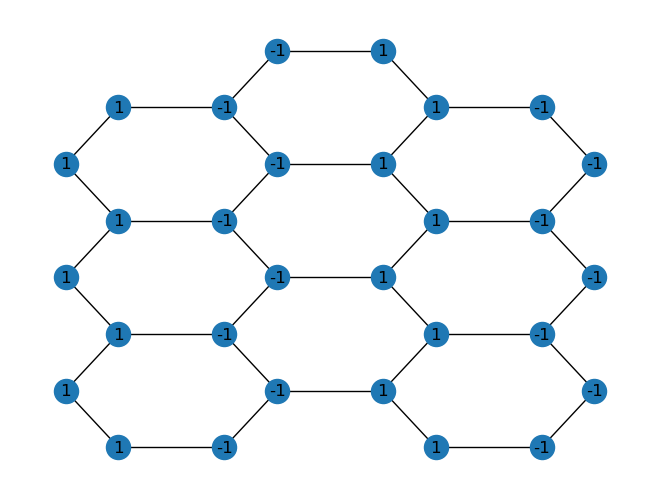

In [6]:
def assign_spin_labels_rucl(lattice_size):
    #We may omit NN and NNN couplings for the purposes of clarity in state prep
    g = hexagonal_lattice_graph(lattice_size, lattice_size)
    spin_labels = dict([(node, pow(-1, node[0])) for node in g])
    nx.set_node_attributes(g, spin_labels, name="spin")
    return g

def prepare_initial_state_rucl(g):
    #site labels are assumed to be the same as for hamiltonian with NN and NNN couplings
    #because they come from the same base generator
    g = flatten_nx_graph(g)
    spins = nx.get_node_attributes(g,"spin")
    qubits = [cirq.LineQubit(i) for i in g.nodes]
    
    #generating layers of operations to initialize state
    layer_zig_zag = [cirq.X(qubits[i]) for i in range(len(g)) if spins[i] == -1]
    layer_rz = [cirq.Rz(rads = np.pi/4).on(qubit) for qubit in qubits]
    layer_rx = [cirq.Rx(rads = np.pi/4).on(qubit) for qubit in qubits]
    layer_z = [cirq.Z(qubit) for qubit in qubits]
    layer_rx_neg = [cirq.Rx(rads=-np.pi/4).on(qubit) for qubit in qubits]
    layer_rz_neg = [cirq.Rz(rads=-np.pi/4).on(qubit) for qubit in qubits]

    #appending layers to a circuit to return
    circuit = cirq.Circuit()
    circuit.append(layer_zig_zag)
    circuit.append(layer_rz)
    circuit.append(layer_rx)
    circuit.append(layer_z)
    circuit.append(layer_rx_neg)
    circuit.append(layer_rz_neg)
    return circuit
    
g_spins = assign_spin_labels_rucl(3)
circuit_state_prep = prepare_initial_state_rucl(g_spins)
pos = nx.get_node_attributes(g_spins, 'pos')
spin_labels = nx.get_node_attributes(g_spins, "spin")
nx.draw(g_spins, labels = spin_labels, pos=pos, with_labels=True)
print(circuit_state_prep)

Finally, it is time to implement the circuit for simulating the time dynamics of $H$, parameterized by the rows of Table 1.  First we perform the simulation using the second order Trotter expansion.  We choose an energy precision of 1e-3, which is believed to be sufficiently low to allow for lower circuit depths while still getting empirically accurate results.  We construct a lattice of size 32x32 honeycomb cells to hopefully have a sufficiently large mass to mitigate finite size effects.  This is believed to be the lower end of what lattice size would be useful, and larger may be better in some cases.  Finally, we plot the a histogram of the T-widths that occur on each layer of the circuit.  The x-axis representing the number of parallel T-gates and the y-axis representing the number of layers where that T-width is found.  This is done to determine the value of the parallelizability of T factories on a theoretical Fault Tolerant Device using a Clifford + T gateset.  

Estimating RuCl row 13 using Trotterization
  Time to estimate Number of steps required: 40.83168820799983 seconds
  Time to find term ordering: 0.023322834000282455 seconds
  Time to generate trotter circuit from openfermion: 1.0000003385357559e-06 seconds
  Time to decompose trotter to Clifford + T: 166.42539187500006 seconds
  Time to enumerate resource estimates: 12.25701683400257 seconds
Total time to estimate RuCl row 13: 277.7311061670007 seconds



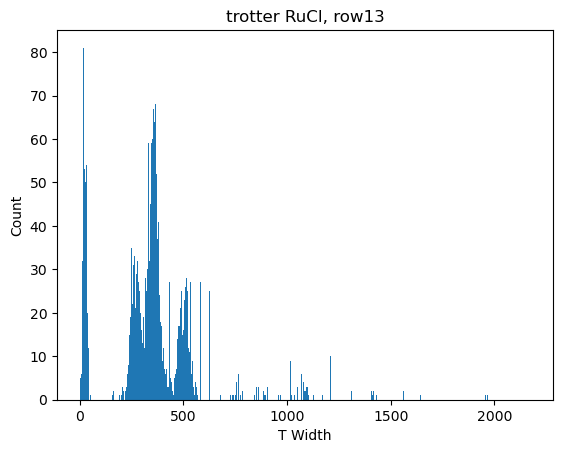

In [7]:
#Commenting out range, to avoid long runtimes.  This still takes ~20-30 minutes as written
for i in [13]:
#for i in range(19):
    #defining precision required for the trotterized circuit
    energy_precision = 1e-3

    figdir="Trotter/Figures/"
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    widthdir = "Trotter/Widths/"
    if not os.path.exists(widthdir):
        os.makedirs(widthdir)

    timesteps=1000
    H_rucl = generate_rucl_hamiltonian(32, df_rucl.iloc[i], field_x=lambda s: 1/sqrt(6), field_y=lambda s: 1/sqrt(6), field_z=lambda s: -2/sqrt(6))
    H_rucl_pyliqtr = pyH(H_rucl)
    openfermion_hamiltonian_rucl = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_rucl_pyliqtr)
    
    print("Estimating RuCl row " + str(i) + " using Trotterization")
    t0 = time.perf_counter()
    cpt_trotter_rucl = estimate_trotter(openfermion_hamiltonian_rucl, timesteps, energy_precision, "Trotter/RuCl_circuits/", hamiltonian_name="rucl_" + str(i), write_circuits=True)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("Total time to estimate RuCl row " + str(i) + ": " + str(elapsed) + " seconds\n")
    
    plot_histogram(cpt_trotter_rucl,
                   f'trotter RuCl, row{i}',
                   figdir,
                   widthdir,
                   0)

Finally we perform the same experiment for the Quantum Signal Processing algorithm.  We omit plotting in this case because we perform estimation of the circuit by decomposing sub-circuits of the overall algorithm.  This results in some sub-circuits where parallelizability may appear deceptively high, or no T gates may even be present.  Emperically, for the portions of the circuit which compose the bulk of the circuit (SELECT and REFLECT operators), the T width tends to be near 1.

In [8]:
#Commenting out range, to avoid long runtimes.  This still takes ~20-30 minutes as written
for i in [13]:
#for i in range(19):
    #defining precision required for the trotterized circuit
    energy_precision = 1e-3
    figdir="QSP/Figures/"
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    widthdir = "QSP/Widths/"
    if not os.path.exists(widthdir):
        os.makedirs(widthdir)
    timesteps=1000
    H_rucl = generate_rucl_hamiltonian(32, df_rucl.iloc[i], field_x=lambda s: 1/sqrt(6), field_y=lambda s: 1/sqrt(6), field_z=lambda s: -2/sqrt(6))
    H_rucl_pyliqtr = pyH(H_rucl)
    
    print("Estimating RuCl row " + str(i) + " using QSP")
    t0 = time.perf_counter()
    #change to Clifford+T dictionary in future revision
    qsp_high_level_rucl = estimate_qsp(H_rucl_pyliqtr, timesteps, energy_precision, "QSP/RuCl_circuits/", hamiltonian_name="rucl_" + str(i))
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("Time to estimate RuCl row " + str(i) + ": " + str(elapsed) + " seconds\n")
    print()

Estimating RuCl row 13 using QSP
  Time to generate high level QSP circuit: 108.5153790000004 seconds
    Time to decompose high level cirq.ops.pauli_gates._PauliX circuit: 0.00013212499834480695 seconds
    Time to transform decomposed cirq.ops.pauli_gates._PauliX circuit to Clifford+T: 1.9249997421866283e-05 seconds
    Time to decompose high level cirq.ops.common_gates.Rx circuit: 4.337499922257848e-05 seconds
    Time to transform decomposed cirq.ops.common_gates.Rx circuit to Clifford+T: 0.00799854199794936 seconds
    Time to decompose high level pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit: 0.5160565420010244 seconds
    Time to transform decomposed pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit to Clifford+T: 114.8914915000023 seconds
    Time to decompose high level cirq.ops.common_gates.Ry circuit: 0.004330166000727331 seconds
    Time to transform decomposed cirq.ops.common_gates.Ry circuit to Clifford+T: 0.41285029

The final observable being measured is net magnetization, which can be obtained by simply measuring all of the qubits in the desired basis (in this case, the $\hat{a}$, $\hat{b}$, $\hat{c}$ basis), and summing the spins on all of the sites.  Since the computational basis is in the $\hat{z}$ direction, we will need to implement a change of basis operation.  For the purposes of this demonstration, we will use the measure in the $\hat{c}$ direction, for which the transformation $R^x_i(\pi/4) \cdot R^z_i(\pi/4)$ applied on each qubit before measurement is sufficient.  This resource requirement, like the requirement for running the state preparation is constant, both in the sense that it needs to be performed for every circuit and in the sense that depth added to the circuit is $\mathcal{O}(1)$. For this reason, we perform the resource estimates for the state preparation and observable measurement separately from the dynamic circuits which are implemented based on Hamiltonian parameterizations. Below, we provide the resource estimates for both the state preparation and measurement (the state preparation circuit generator is defined above)

In [9]:
def prepare_measurement_rucl(g):
    #site labels are assumed to be the same as for hamiltonian with NN and NNN couplings
    #because they come from the same base generator
    g = flatten_nx_graph(g)
    qubits = [cirq.LineQubit(i) for i in g.nodes]
    
    #generating layers of operations to initialize state
    layer_rz = [cirq.Rz(rads = np.pi/4).on(qubit) for qubit in qubits]
    layer_rx = [cirq.Rx(rads = np.pi/4).on(qubit) for qubit in qubits]
    layer_measurement = [cirq.measure(qubit) for qubit in qubits]
    #appending layers to a circuit to return
    circuit = cirq.Circuit()
    circuit.append(layer_rz)
    circuit.append(layer_rx)
    circuit.append(layer_measurement)
    return circuit

#example instance for clear printing and verification of the correct operators
circuit_measurement = prepare_measurement_rucl(g_spins)
print(circuit_measurement)

0: ────Rz(0.25π)───Rx(0.25π)───M───

1: ────Rz(0.25π)───Rx(0.25π)───M───

2: ────Rz(0.25π)───Rx(0.25π)───M───

3: ────Rz(0.25π)───Rx(0.25π)───M───

4: ────Rz(0.25π)───Rx(0.25π)───M───

5: ────Rz(0.25π)───Rx(0.25π)───M───

6: ────Rz(0.25π)───Rx(0.25π)───M───

7: ────Rz(0.25π)───Rx(0.25π)───M───

8: ────Rz(0.25π)───Rx(0.25π)───M───

9: ────Rz(0.25π)───Rx(0.25π)───M───

10: ───Rz(0.25π)───Rx(0.25π)───M───

11: ───Rz(0.25π)───Rx(0.25π)───M───

12: ───Rz(0.25π)───Rx(0.25π)───M───

13: ───Rz(0.25π)───Rx(0.25π)───M───

14: ───Rz(0.25π)───Rx(0.25π)───M───

15: ───Rz(0.25π)───Rx(0.25π)───M───

16: ───Rz(0.25π)───Rx(0.25π)───M───

17: ───Rz(0.25π)───Rx(0.25π)───M───

18: ───Rz(0.25π)───Rx(0.25π)───M───

19: ───Rz(0.25π)───Rx(0.25π)───M───

20: ───Rz(0.25π)───Rx(0.25π)───M───

21: ───Rz(0.25π)───Rx(0.25π)───M───

22: ───Rz(0.25π)───Rx(0.25π)───M───

23: ───Rz(0.25π)───Rx(0.25π)───M───

24: ───Rz(0.25π)───Rx(0.25π)───M───

25: ───Rz(0.25π)───Rx(0.25π)───M───

26: ───Rz(0.25π)───Rx(0.25π)───M───

2

In [10]:
g_spins = assign_spin_labels_rucl(32)
circuit_state_prep_and_measurement = prepare_initial_state_rucl(g_spins) + prepare_measurement_rucl(g_spins)
circuit_state_prep_and_measurement_cpt = clifford_plus_t_direct_transform(circuit_state_prep_and_measurement)


In [11]:
get_cpt_estimate(circuit_state_prep_and_measurement_cpt, circuit_name = "state preparation and measurement")

{'num_qubits': 2176,
 't_count': 13056,
 't_depth': 11,
 't_depth_wire': 6,
 'gate_count': 31520,
 'clifford_count': 18464,
 'circuit_depth': 15,
 'circuit_name': 'state preparation and measurement'}

In [12]:
t_end = time.perf_counter()
print("Total time to run notebook (only using the fastest row): " + str(t_end - t_init))

Total time to run notebook (only using the fastest row): 680.8369614160001


### References
[1] Laurell, P., Okamoto, S. Dynamical and thermal magnetic properties of the Kitaev spin liquid candidate α-RuCl3. npj Quantum Mater. 5, 2 (2020). https://doi.org/10.1038/s41535-019-0203-y